<a href="https://colab.research.google.com/github/Sandesh02/FSM-INT-2022/blob/main/Deep_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [36]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the Dataset

In [37]:

# define column names for easy indexing
index_names = ['unit', 'cycles']
setting_names = ['OPsetting_1', 'OPsetting_2', 'OPsetting_3']
sensor_names = ['sensor {}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/_train_FD001.txt',sep='\s+', header=None, names=col_names)
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/_test_FD001.txt',sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/_RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()

,unit,cycles,OPsetting_1,OPsetting_2,OPsetting_3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [22]:
train['unit'].unique()

# There are 100 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
therefore the test dataset will be subsetted to represent the same.

In [23]:
test.shape

(13096, 26)

In [38]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
test = test.groupby('unit').last().reset_index()

In [39]:
y_test.shape

# RUL value for 100 no of engines.

(100, 1)

In [40]:
test.shape
# Now test data contains entries for 100 no of engines with their RUL.

(100, 26)

In [41]:
# Adding RUL (Ramining Useful Life) to the train dataset

In [42]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit")
    max_cycle = grouped_by_unit["cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,sensor 6,sensor 7,sensor 8,sensor 9,sensor 10,...,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21,RUL
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [43]:
train.head(5)

,unit,cycles,OPsetting_1,OPsetting_2,OPsetting_3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,...,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [44]:
delete_columns=['unit',
 'OPsetting_1',
 'OPsetting_2',
 'OPsetting_3',
 'sensor 1',
 'sensor 5',
 'sensor 6',
 'sensor 9',
 'sensor 10',
 'sensor 14',
 'sensor 16',
 'sensor 18',
 'sensor 19']
train = train.drop(columns=delete_columns,axis=1)
train.head()

,cycles,sensor 2,sensor 3,sensor 4,sensor 7,sensor 8,sensor 11,sensor 12,sensor 13,sensor 15,sensor 17,sensor 20,sensor 21,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


## Seperating Train & Test Data

In [45]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['RUL'],axis=1)
X_train.head(5)

,cycles,sensor 2,sensor 3,sensor 4,sensor 7,sensor 8,sensor 11,sensor 12,sensor 13,sensor 15,sensor 17,sensor 20,sensor 21
0,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044


In [46]:
test.head(5)

,unit,cycles,OPsetting_1,OPsetting_2,OPsetting_3,sensor 1,sensor 2,sensor 3,sensor 4,sensor 5,...,sensor 12,sensor 13,sensor 14,sensor 15,sensor 16,sensor 17,sensor 18,sensor 19,sensor 20,sensor 21
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [47]:
# Test data set , keeping only train columns/features.
X_test=test[X_train.columns]
X_test.head(5)

,cycles,sensor 2,sensor 3,sensor 4,sensor 7,sensor 8,sensor 11,sensor 12,sensor 13,sensor 15,sensor 17,sensor 20,sensor 21
0,31,642.58,1581.22,1398.91,554.42,2388.08,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,49,642.55,1586.59,1410.83,553.52,2388.10,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,126,642.88,1589.75,1418.89,552.59,2388.16,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,106,642.78,1594.53,1406.88,552.64,2388.13,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,98,642.27,1589.94,1419.36,553.29,2388.10,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


In [48]:
y_test.head(5)

,RUL
0,112
1,98
2,69
3,82
4,91


In [49]:
# Clipping of RUL at 125 as after 125 , RUL is responding to the sensor values after this value.
# This is done to improve performance of the applied models.

y_train= y_train.clip(upper=125)

## Building Model

In [50]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

### Model 1: Linear Regression

In [51]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_test1 = sc.transform(X_test)

In [52]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train1, y_train)

# predict and evaluate
y_hat_train1 = lm.predict(X_train1)
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1,'train')

y_hat_test1 = lm.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1,'test')

train set RMSE:20.67370812619755, R2:0.7538874761535628
test set RMSE:23.465824720302138, R2:0.6811311463216777


In [54]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model':['Linear'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]})
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131


Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Train Data')

<Figure size 432x288 with 0 Axes>

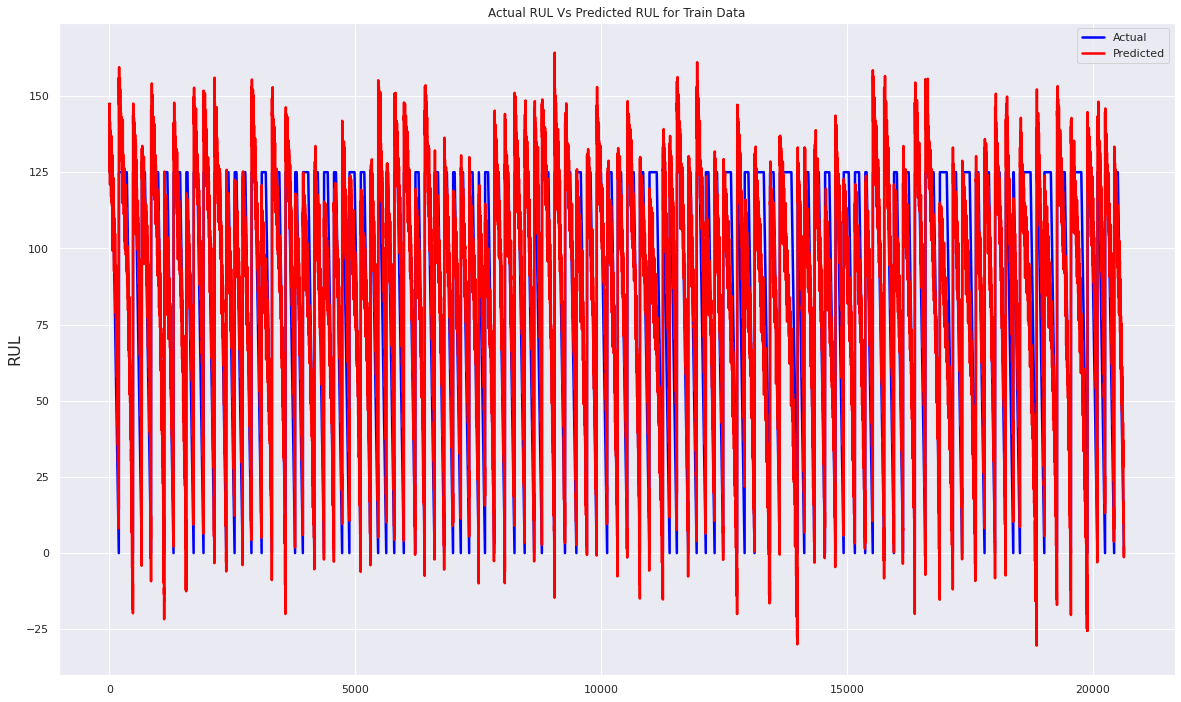

In [55]:
# Plot Actual Vs Predicted RUL for Train Data
#c = [i for i in range(1,81,1)]
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(y_train,color="blue", linewidth=2.5, linestyle="-",label="Actual")
plt.plot(y_hat_train1,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
fig.suptitle('Actual and Predicted', fontsize=20)            # Plot heading 
#plt.xlabel('Index', fontsize=18)                            # X-label
plt.ylabel('RUL', fontsize=16)                               # Y-label
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Train Data")


In [56]:
# Making predictions using test set
y_hat_test1 = lm.predict(X_test1)
evaluate(y_test, y_hat_test1)


test set RMSE:23.465824720302138, R2:0.6811311463216777


(23.465824720302138, 0.6811311463216777)

Text(0.5, 1.0, 'Actual RUL Vs Predicted RUL for Test Data')

<Figure size 432x288 with 0 Axes>

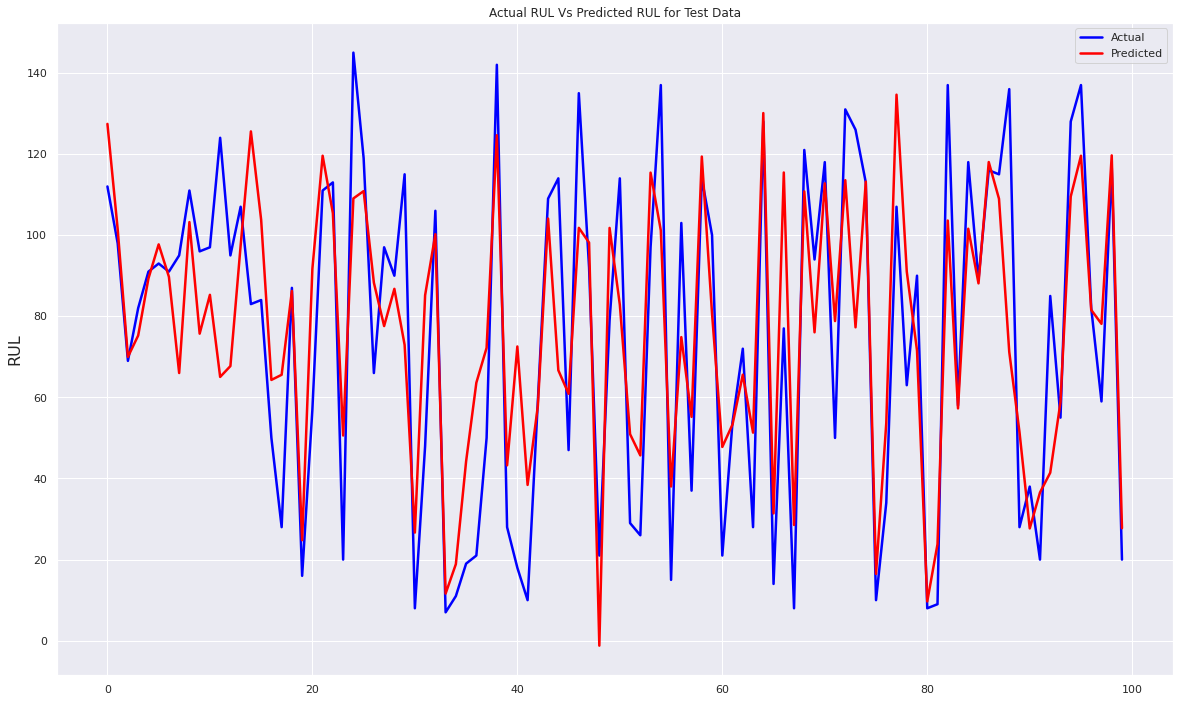

In [58]:
# Plot Actual Vs Predicted RUL for Test Data
#c = [i for i in range(1,81,1)]
fig = plt.figure();
plt.figure(figsize=[20,12])
plt.plot(y_test,color="blue", linewidth=2.5, linestyle="-",label="Actual")
plt.plot(y_hat_test1,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
#plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('RUL', fontsize=16)                               # Y-label
plt.legend()
plt.title("Actual RUL Vs Predicted RUL for Test Data")


- We can see that on test data which is unseen by the model , RMSE & R2 score value comes out be 23.465824720302138,0.6811311463216777

### Model 2 : Applying SVM Model

In [59]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train1, y_train)

# predict and evaluate
y_hat_train1 = regressor.predict(X_train1)
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1)

y_hat_test1 = regressor.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)


test set RMSE:18.014102799925713, R2:0.8131374691954119
test set RMSE:21.50711710875731, R2:0.7321418558009236


In [60]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['SVM'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131
1,SVM,18.014103,0.813137,21.507117,0.732142


- It is clear that RMSE for both test & train model has increased after applying SVM Model.

### Model 3 : Using Decision Tree

In [61]:
from sklearn.tree import DecisionTreeRegressor

In [62]:
dt = DecisionTreeRegressor(random_state=42, max_depth=15, min_samples_leaf=10)

In [63]:
dt.fit(X_train1, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=10, random_state=42)

In [64]:
y_hat_train1 = dt.predict(X_train1)

In [65]:
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:13.965300831045012, R2:0.887695400405719


In [66]:
y_hat_test1 = dt.predict(X_test1)

In [67]:
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:25.365630535573537, R2:0.6274094972386908


In [68]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['DT'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131
1,SVM,18.014103,0.813137,21.507117,0.732142
2,DT,13.965301,0.887695,25.365631,0.627409


- RMSE & R2 score has increased on test set. There is some overfitting happening as the maximum depth of model high.

### Model 4 : Using Random Forest

In [69]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=6, min_samples_leaf=5)
rf.fit(X_train1, y_train)
y_hat_train1 = rf.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:17.389577035569484, R2:0.825869442436337


In [70]:
# Evaluating on Test Data Set
y_hat_test1 = rf.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:21.21630931369726, R2:0.7393365539039676


In [72]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['Random forest'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131
1,SVM,18.014103,0.813137,21.507117,0.732142
2,DT,13.965301,0.887695,25.365631,0.627409
3,DF,17.389577,0.825869,21.216309,0.739337
4,Random forest,17.389577,0.825869,21.216309,0.739337


In [88]:

Results.drop(3)

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131
1,SVM,18.014103,0.813137,21.507117,0.732142
2,DT,13.965301,0.887695,25.365631,0.627409
4,Random forest,17.389577,0.825869,21.216309,0.739337


-R2 score on test is incresed so we can say that our model is not overfitting.



In [89]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf.feature_importances_})

In [90]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
6,sensor 11,0.668790
0,cycles,0.241106
3,sensor 4,0.045520
9,sensor 15,0.010964
7,sensor 12,0.010428
4,sensor 7,0.007322
2,sensor 3,0.003965
12,sensor 21,0.003789
1,sensor 2,0.003713
11,sensor 20,0.001621


- Above is the list of important features/sensors which have strong relation with RUL.

- Using Grid Search for Hyperparameter Tuning

In [91]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42, n_jobs=-1)


In [92]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4,5,6],
    'n_estimators': [10, 30, 50, 100]
}

In [93]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1)

In [95]:
%%time
grid_search.fit(X_train1, y_train)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits
CPU times: user 25 s, sys: 1.64 s, total: 26.7 s
Wall time: 19min 44s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100]},
             verbose=1)

In [96]:
rf_best = grid_search.best_estimator_

In [97]:
y_hat_train = rf_best.predict(X_train1)

In [98]:
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:17.389577035569484, R2:0.825869442436337


In [99]:
# Evaluating on Test Data Set
y_hat_test1 = rf_best.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:20.412716859904766, R2:0.7587084690108389


In [100]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['Random Forest with Tuning'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131
1,SVM,18.014103,0.813137,21.507117,0.732142
2,DT,13.965301,0.887695,25.365631,0.627409
3,DF,17.389577,0.825869,21.216309,0.739337
4,Random forest,17.389577,0.825869,21.216309,0.739337
5,Random Forest with Tuning,17.389577,0.825869,20.412717,0.758708


- DF with hyperparamater tuning model perfomance has further improved.

### Model 5 : Using Ridge Regression

In [101]:
# list pf alphas

from sklearn.linear_model import Ridge, Lasso
params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                     cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train1, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, verbose=1)

In [102]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
25,500,0.755465,0.736830,2
24,100,0.755635,0.736000,3
23,50,0.755641,0.735870,4
22,20,0.755643,0.735789,5
21,10.0,0.755643,0.735761,6
20,9.0,0.755643,0.735758,7
19,8.0,0.755643,0.735756,8
18,7.0,0.755643,0.735753,9
17,6.0,0.755643,0.735750,10
16,5.0,0.755643,0.735747,11


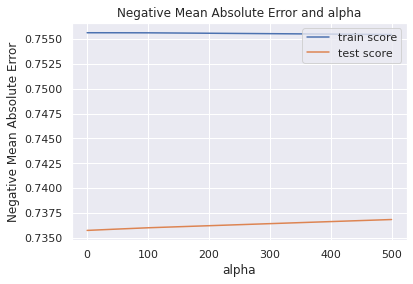

In [103]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [104]:
# get the best estimator for lambda

ridge_model_cv.best_estimator_

Ridge(alpha=1000)

In [105]:
# check the coefficient values with lambda = 10

alpha = 1000
ridge = Ridge(alpha=alpha)

ridge.fit(X_train1, y_train)
ridge.coef_

array([-12.53891692,  -2.88658976,  -2.67510885,  -4.29394019,
         3.07857197,   2.12703517,  -5.14538906,   3.20947561,
         2.14540552,  -3.74931451,  -3.03687447,   2.77664381,
         2.87156253])

In [106]:
y_hat_train1 = ridge.predict(X_train1)
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:20.69058903070625, R2:0.7534853907427672


In [107]:
# Evaluating on Test Data Set
y_hat_test1 = ridge.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:23.402943101994232, R2:0.68283780904176


In [108]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['Ridge'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131
1,SVM,18.014103,0.813137,21.507117,0.732142
2,DT,13.965301,0.887695,25.365631,0.627409
3,DF,17.389577,0.825869,21.216309,0.739337
4,Random forest,17.389577,0.825869,21.216309,0.739337
5,Random Forest with Tuning,17.389577,0.825869,20.412717,0.758708
6,Ridge,20.690589,0.753485,23.402943,0.682838


- Perfomance have reduced with Ridge Regression Model. We need to apply Hyper paramter tuning to improve the perfomance.

### Model 6 : XG Boost Algorithm

In [113]:
import xgboost as xg
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
xgb_r.fit(X_train1, y_train)


[11:58:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=10, seed=123)

In [114]:
# Evaluating on Train Data Set
y_hat_train1 = xgb_r.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:37.992432358713415, R2:0.16882752872824536


In [115]:
# Evaluating on Test Data Set
y_hat_test1 = xgb_r.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1)

test set RMSE:36.45759701971993, R2:0.2303087734868391


In [116]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['XgBoost'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131
1,SVM,18.014103,0.813137,21.507117,0.732142
2,DT,13.965301,0.887695,25.365631,0.627409
3,DF,17.389577,0.825869,21.216309,0.739337
4,Random forest,17.389577,0.825869,21.216309,0.739337
5,Random Forest with Tuning,17.389577,0.825869,20.412717,0.758708
6,Ridge,20.690589,0.753485,23.402943,0.682838
7,XgBoost,37.992432,0.168828,36.457597,0.230309
8,XgBoost,37.992432,0.168828,36.457597,0.230309


In [117]:
Results.drop(8)

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131
1,SVM,18.014103,0.813137,21.507117,0.732142
2,DT,13.965301,0.887695,25.365631,0.627409
3,DF,17.389577,0.825869,21.216309,0.739337
4,Random forest,17.389577,0.825869,21.216309,0.739337
5,Random Forest with Tuning,17.389577,0.825869,20.412717,0.758708
6,Ridge,20.690589,0.753485,23.402943,0.682838
7,XgBoost,37.992432,0.168828,36.457597,0.230309


### Model 6 : Neural Network Model

In [118]:
import tensorflow as tf

In [119]:
ann = tf.keras.models.Sequential()

In [120]:
ann.add(tf.keras.layers.Dense(units=26, activation='relu'))#hidden layer

In [121]:
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))#hidden layer

In [122]:
ann.add(tf.keras.layers.Dense(units=10, activation='relu'))#hidden layer

In [123]:
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))#output layer

In [124]:
ann.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])# Compiling the ANN


In [125]:
ann.fit(X_train1, y_train, batch_size = 32, epochs = 75)

Epoch 1/75
645/645 [==============================] - 2s 2ms/step - loss: 3634.8760 - mae: 47.9451
Epoch 2/75
645/645 [==============================] - 1s 2ms/step - loss: 471.6954 - mae: 17.5536
Epoch 3/75
645/645 [==============================] - 1s 2ms/step - loss: 425.7330 - mae: 16.6896
Epoch 4/75
645/645 [==============================] - 1s 2ms/step - loss: 403.8461 - mae: 16.1739
Epoch 5/75
645/645 [==============================] - 1s 2ms/step - loss: 385.0728 - mae: 15.6673
Epoch 6/75
645/645 [==============================] - 1s 2ms/step - loss: 343.2205 - mae: 14.4653
Epoch 7/75
645/645 [==============================] - 1s 2ms/step - loss: 319.8900 - mae: 13.7086
Epoch 8/75
645/645 [==============================] - 1s 2ms/step - loss: 314.5624 - mae: 13.4963
Epoch 9/75
645/645 [==============================] - 1s 2ms/step - loss: 311.2402 - mae: 13.3492
Epoch 10/75
645/645 [==============================] - 1s 2ms/step - loss: 309.4626 - mae: 13.2786
Epoch 11/75
645/64

In [126]:
# Evaluating on Train Data Set
y_hat_train1 = ann.predict(X_train1)
# Evaluating on Train Data Set
RMSE_Train,R2_Train=evaluate(y_train, y_hat_train1, 'train')

train set RMSE:16.712369110466256, R2:0.839167804379198


In [127]:
# Evaluating on Test Data Set
y_hat_test1 = ann.predict(X_test1)
RMSE_Test,R2_Test=evaluate(y_test, y_hat_test1,'test')

test set RMSE:20.89214252499919, R2:0.7472411238897948


In [128]:
# Make Dataframe which will contain results of all applied Model
Results=Results.append(pd.DataFrame({'Model':['ANN'],'RMSE-Train':[RMSE_Train],'R2-Train':[R2_Train],'RMSE-Test':[RMSE_Test],'R2-Test':[R2_Test]}),ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,Linear,20.673708,0.753887,23.465825,0.681131
1,SVM,18.014103,0.813137,21.507117,0.732142
2,DT,13.965301,0.887695,25.365631,0.627409
3,DF,17.389577,0.825869,21.216309,0.739337
4,Random forest,17.389577,0.825869,21.216309,0.739337
5,Random Forest with Tuning,17.389577,0.825869,20.412717,0.758708
6,Ridge,20.690589,0.753485,23.402943,0.682838
7,XgBoost,37.992432,0.168828,36.457597,0.230309
8,XgBoost,37.992432,0.168828,36.457597,0.230309
9,ANN,16.712369,0.839168,20.892143,0.747241


- With ANN model perfomance is incresed

## Conclusion

from the above trained models accuracy of ANN is good using this model we can do further process.
On ANN hyperparametre tunning can done to improve accuracy.